In [4]:
from torch.utils.data import DataLoader
import pandas as pd
import torch as th 
import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
import PIL


import src.classification as lc
import src.data_loader as dl

%matplotlib inline  
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
PIL.Image.MAX_IMAGE_PIXELS = 108000001


In [11]:
def plot_confusion(y_t, y_p, labels):
    cm = confusion_matrix(y_t, y_p)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    
    
@th.no_grad()
def predict(model, data_loader):
    y_t, y_p = [], []
    
    for bs in tqdm.tqdm(data_loader):
        x = bs['img'].cuda()
        y_t.append(bs['label'].argmax(dim=1).detach().cpu().numpy())
        y_p.append(model(x).argmax(dim=1).detach().cpu().numpy())
        
    return np.concatenate(y_t), np.concatenate(y_p)

In [33]:
# model_checkpoint = '/home/cemmi/Documents/aicrowd-mos/Mosquito-Classifiction/lightning_logs/version_3/checkpoints/epoch=4-val_loss=0.2824241518974304-val_accuracy=0.9133956432342529-val_multiclass_accuracy=0.7767815589904785.ckpt'
# model_checkpoint = '/home/cemmi/Documents/aicrowd-mos/Mosquito-Classifiction/lightning_logs/version_18/checkpoints/epoch=1-val_loss=0.25722965598106384-val_accuracy=0.9121495485305786-val_multiclass_accuracy=0.8630045652389526.ckpt'

version = '29'
model_name = 'epoch=2-val_loss=0.29584163427352905-val_accuracy=0.9183968901634216-val_multiclass_accuracy=0.8534045815467834'
model_checkpoint = f'./lightning_logs/version_{version}/checkpoints/{model_name}.ckpt'

img_dir = "../data_round_2/final"
annotations_csv = "../data_round_2/phase2_train_v0.csv"
class_dict = {
    "albopictus": th.tensor([1, 0, 0, 0, 0, 0], dtype=th.float),
    "culex": th.tensor([0, 1, 0, 0, 0, 0], dtype=th.float),
    "japonicus/koreicus": th.tensor([0, 0, 1, 0, 0, 0], dtype=th.float),
    "culiseta": th.tensor([0, 0, 0, 1, 0, 0], dtype=th.float),
    "anopheles": th.tensor([0, 0, 0, 0, 1, 0], dtype=th.float),
    "aegypti": th.tensor([0, 0, 0, 0, 0, 1], dtype=th.float),
}

labels = list(class_dict.keys())
transform = dl.pre_process("")
bs = 256

In [8]:
model = lc.MosquitoClassifier.load_from_checkpoint(model_checkpoint).eval().cuda()

In [9]:
annotations_df = pd.read_csv(annotations_csv)
train_df = annotations_df.sample(frac=0.8, random_state=200)
val_df = annotations_df.drop(train_df.index)


train_dataset = dl.SimpleClassificationDataset(
    train_df,
    img_dir,
    class_dict,
    transform,
    dl.aug("resize"),
    class_balance=False,
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=bs,
    shuffle=False,
    num_workers=6,
)

val_dataset = dl.SimpleClassificationDataset(
    val_df,
    img_dir,
    class_dict,
    transform,
    dl.aug("resize"),
    class_balance=False,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=bs,
    shuffle=False,
    num_workers=6,
)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:38<00:00,  4.24s/it]


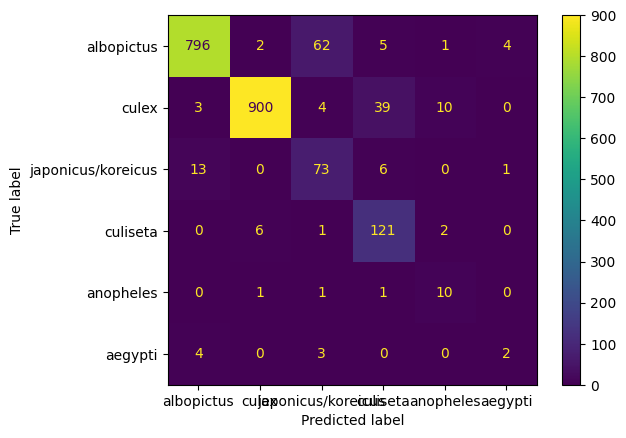

In [12]:
v_t, v_p = predict(model, val_dataloader)
plot_confusion(v_t, v_p, labels)


In [13]:
f1_score(v_t, v_p, average='macro')

0.6887180008442048

In [14]:
# 0.61 f1 val version_3 epoch=4
# 0.66 f1 val version_18 epoch=1
# 0.54 f1 val version_1 epoch=1
# 0.56 f1 val version_11 epoch=1
# 0.56 f1 val version_16 epoch=3
# 0.66 f1 val version_19 epoch=1
# 0.64 f1 val version_26 epoch=1
# 0.76 f1 val version_26 epoch=3
# 0.77 f1 val version_26 epoch=4
# 0.66 f1 val version_28 epoch=4
# 0.62 f1 val version_28 epoch=2
# 0.57 f1 val version_27 epoch=4
# 0.53 f1 val version_27 epoch=2

100%|██████████████████████████████████████████████████████████████████████████████████████████| 33/33 [01:50<00:00,  3.33s/it]


0.8699730950979174

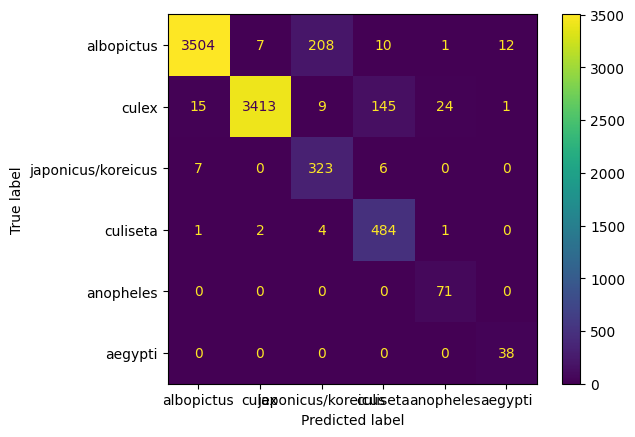

In [15]:
t_t, t_p = predict(model, train_dataloader)
plot_confusion(t_t, t_p, labels)

f1_score(t_t, t_p, average='macro')

# Compare CPU vs GPU resul

In [34]:
model_cpu = lc.MosquitoClassifier.load_from_checkpoint(model_checkpoint).eval().cpu()
model_gpu = lc.MosquitoClassifier.load_from_checkpoint(model_checkpoint).eval().cuda()

In [35]:
model_checkpoint

'./lightning_logs/version_29/checkpoints/epoch=2-val_loss=0.29584163427352905-val_accuracy=0.9183968901634216-val_multiclass_accuracy=0.8534045815467834.ckpt'

In [36]:
val_dataloader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=6,
)


with th.no_grad():
    print('From Real Images')
    for i, bs in enumerate(val_dataloader):
        if i > 10:
            break
        img = bs['img']
        r_c = model_cpu(img)
        r_g = model_gpu(img.to('cuda'))
    
        print("CPU", r_c[0])
        print("GPU", r_g[0])
        print('=========')



From Real Images
CPU tensor([ 4.6555, -2.8319,  0.8391, -3.6518, -0.8794,  1.2030])
GPU tensor([ 4.6555, -2.8319,  0.8391, -3.6518, -0.8795,  1.2030], device='cuda:0')
CPU tensor([ 4.7234, -1.9283,  0.6089, -3.7057, -1.9895,  0.2144])
GPU tensor([ 4.7234, -1.9283,  0.6089, -3.7057, -1.9895,  0.2144], device='cuda:0')
CPU tensor([ 2.7304, -0.8722,  0.7962, -3.3529, -0.9907,  0.9629])
GPU tensor([ 2.7304, -0.8722,  0.7962, -3.3529, -0.9907,  0.9629], device='cuda:0')
CPU tensor([-2.3435,  4.1989, -1.9405,  1.7908,  0.8980, -1.6143])
GPU tensor([-2.3435,  4.1989, -1.9405,  1.7908,  0.8980, -1.6143], device='cuda:0')
CPU tensor([-3.2505, -1.5928, -1.1634,  5.0503, -1.1633, -0.5984])
GPU tensor([-3.2505, -1.5928, -1.1634,  5.0503, -1.1633, -0.5984], device='cuda:0')
CPU tensor([-2.1057,  2.1543, -1.4572,  0.4159, -1.1079, -2.1182])
GPU tensor([-2.1057,  2.1543, -1.4572,  0.4159, -1.1079, -2.1181], device='cuda:0')
CPU tensor([-3.1463,  4.9215, -2.8017,  1.6815, -0.4281, -2.0215])
GPU tensor

# YOLO Submission

In [21]:
# Submit


test_annotation = './yolo/submissions_yolo_m.csv'
test_dir = '/home/cemmi/Documents/aicrowd-mos/data/test'

test_df = pd.read_csv(test_annotation)
test_dataset = dl.SimpleClassificationDataset(
    test_df,
    test_dir,
    class_dict,
    transform,
    dl.aug("resize"),
    class_balance=False,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=bs,
    shuffle=False,
    num_workers=6,
)
_, test_p = predict(model, test_dataloader)

p_labels = [labels[c] for c in test_p]

test_df['class_label'] = p_labels

100%|███████████████████████████████████████████████████████████████| 11/11 [00:45<00:00,  4.18s/it]


In [22]:
test_df.to_csv('submissions_yolo_m_clip_v_26_vit_l_epoch=4.csv', index=False)

# Ensemble

In [59]:
n = 10
W = [i/n for i in range(0, n+1)]
f1_vals = []

version1 = '19'
model_name1 = 'epoch=1-val_loss=0.2737879455089569-val_accuracy=0.9109034538269043-val_multiclass_accuracy=0.822079598903656'
model_checkpoint1 = f'./lightning_logs/version_{version}/checkpoints/{model_name}.ckpt'

version2 = '18'
model_name2 = 'epoch=1-val_loss=0.25722965598106384-val_accuracy=0.9121495485305786-val_multiclass_accuracy=0.8630045652389526'
model_checkpoint2 = f'./lightning_logs/version_{version}/checkpoints/{model_name}.ckpt'

backbone = lc.MosquitoClassifier.load_from_checkpoint(model_checkpoint1).cpu()
model2 = lc.MosquitoClassifier.load_from_checkpoint(model_checkpoint2).cpu()

with th.no_grad():
    for w in W:
        model = lc.MosquitoClassifier(head_version=2)
        model.load_state_dict(model2.state_dict())

        for o, b in zip(model.parameters(), backbone.parameters()):
            o.data = w*o + (1 - w)*b
        
        model.eval()
        model.cuda()
        v_t, v_p = predict(model, val_dataloader)
        
        print(v_p)
        f1_val = f1_score(v_t, v_p, average='macro')
        print(f'Weight {w} - val score {f1_val}')
        f1_vals.append(f1_val)


100%|██████████████████████████████████████| 7/7 [00:34<00:00,  4.97s/it]


Weight 0.0 - val score 0.6647083746693502


100%|██████████████████████████████████████| 7/7 [00:34<00:00,  4.95s/it]


Weight 0.1 - val score 0.6647083746693502


100%|██████████████████████████████████████| 7/7 [00:35<00:00,  5.02s/it]


Weight 0.2 - val score 0.6647083746693502


100%|██████████████████████████████████████| 7/7 [00:34<00:00,  4.90s/it]


Weight 0.3 - val score 0.6647083746693502


100%|██████████████████████████████████████| 7/7 [00:34<00:00,  4.90s/it]


Weight 0.4 - val score 0.6647083746693502


100%|██████████████████████████████████████| 7/7 [00:35<00:00,  5.07s/it]


Weight 0.5 - val score 0.6647083746693502


100%|██████████████████████████████████████| 7/7 [00:35<00:00,  5.10s/it]


Weight 0.6 - val score 0.6647083746693502


 43%|████████████████▎                     | 3/7 [00:28<00:38,  9.66s/it]


KeyboardInterrupt: 